## Importe das bibiliotecas utilizadas no código


In [3]:
from tqdm import tqdm
import math
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import cv2 as cv
import sys
import os
import imutils

## Função Objetivo
A Função Objetivo será o próprio algoritmo de visão computacional para contar o número de neurônios. Os parâmetros, treshhold e contraste, serão os atributos do cromossomo

In [4]:

# Funcao Objetivo
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    
    blurred = cv.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    #cv.imshow("Display window", sharpened)
    return sharpened

def getCount(image,treshold,contrast):
    
    f = 131*(contrast + 127)/(127*(131-contrast))
    alpha_c = f
    gamma_c = 127*(1-f)
    new_image = cv.addWeighted( image, alpha_c, image, 0, gamma_c) #add contrast for image
    image = unsharp_mask(new_image) 
    image_blur_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    image_res ,image_thresh = cv.threshold(image_blur_gray,treshold,255,cv.THRESH_BINARY_INV) #get threshold image

    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(image_thresh,cv.MORPH_OPEN,kernel) 

    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5) 
    _, last_image =  cv.threshold(dist_transform, 0.3*dist_transform.max(),255,0)

    last_image2 = np.uint8(last_image)
    cnts = cv.findContours(last_image2.copy(), cv.RETR_EXTERNAL,	cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    return len(cnts)


def check_neuron(path,treshold, contrast):
    for str_file in os.listdir(path):
        filename = f"{path}/{str_file}"
        image = cv.imread(filename)
        count = getCount(image,treshold, contrast)
        print(count)
        

def funcao_objetivo(populacao,filename):
    arr = []
    image = cv.imread(filename)
    for i in tqdm(range(len(populacao))):
        count = getCount(image,populacao.loc[i]["treshold"], populacao.loc[i]["contrast"])
        arr.append(count)
        
    return arr
    

## Função Fitness
A função de aptidão escolhida, foi a Atribuição proporcional de aptidão. Nesta função a aptidão de cada indívduo é dado pela razão do valor obtido na função objetivo em relação ao total de todos os indivíduos.

In [5]:
def aptidao_proporcional(df):
    Fx = []
    sum_fx = sum(df['fx'])
    for i, row in df.iterrows():
        Fx.append(row['fx']/sum_fx)
    return Fx

## Mutação Uniforme
A mutação escolhida foi a uniforme. Neste caso, se para o atributo do individuo, se o valor randômico for menor que a taxa de mutação (5%) será atribuído um valor randômico do espaço de busca (entre 0 e 255).

In [6]:
# Mutacao
def mutacao_uniforme(individuo, tx_mutacao):
    individuo_mutado = []
    # como a taxa de mutacao eh entre 0 e 1, temos:
    rand_treshrold = np.random.random()
    if rand_treshrold < tx_mutacao:
        individuo_mutado.append(np.random.randint(0, 255))
    else:
        individuo_mutado.append(individuo[0])
    
    rand_contrast = np.random.random()
    if rand_contrast < tx_mutacao:
        individuo_mutado.append(np.random.randint(0, 130))
    else:
        individuo_mutado.append(individuo[1])
    
    return individuo_mutado

## Crossover Aritmético
O crossover escolhido foi o aritmético. Aqui, um valor randomico alfa é selecionado. Esse alfa será utilizado para fazer combinação linear dos atributos dos pais para a geração dos filhos, caso seja menor que a taxa de crosover.

In [7]:
def crossover(P1, P2, tx_crossover):
    C1 = P1
    C2 = P2
    alpha = np.random.random()
    rand_c = np.random.random()
    rand_t = np.random.random()


    if tx_crossover > rand_c:
        #a
        t = int(alpha*P1[0] + (1 - alpha)*P2[0])
        s = int(alpha*P2[0] + (1 - alpha)*P1[0])
        
        if (t >= 0 and t <= 255 and s >= 0 and s <= 255):
            C1[0] = t
            C2[0] = s
    
    if tx_crossover > rand_t:
        #a
        t = int(alpha*P1[1] + (1 - alpha)*P2[1])
        s = int(alpha*P2[1] + (1 - alpha)*P1[1])
        
        if (t >= 0 and t <= 130 and s >= 0 and s <= 130):
            C1[1] = t
            C2[1] = s

    return (C1, C2)

## Metodo de Selecao : Roleta
Usando o Ranking Linear para fazer a soma acumulada, o indivíduo é escolhido com base num valor randômico (no caso utilizamos a função ```random.triangular()```, que aumenta a probabilidade do valor escolhido estar próximo de um ponto escolhido, dessa forma queremos priorizar a escolha de melhores indivíduos).

In [8]:
# Metodo de selecao - roleta
def selecao_roleta(Fx, df):
    posicao = 0
    soma_acumulada = np.cumsum(Fx)
    #tamanho = len(Fx)
    #limite = soma_acumulada[tamanho-1]
    #divisao = np.random.randint(1,9)
    rand = np.random.uniform(0, 1)

    for i, valor in enumerate(soma_acumulada):
        if rand <= valor:
            posicao = i
            break
    
    return df.loc[posicao]

In [9]:
def plot_geracao_3d(df, geracao):
    populacao = df.copy()
    if geracao%5 == 0:
        print("Geracao: ", geracao)
        fig = plt.figure(figsize= (16,9))
        ax = plt.axes(projection = '3d')
        
        ax.grid(b = True, color = 'grey', linestyle = '-.', linewidth = 0.3, alpha = 0.2)
        
        my_cmap = plt.get_cmap('hsv')
        
        sctt = ax.scatter3D(populacao['treshold'],populacao['contrast'], populacao["fx"], alpha = 0.8, c=populacao["fx"], cmap= my_cmap, marker = '.')
        
        plt.title(f"Geracao {geracao}")
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('f(x1,x2)')
        fig.colorbar(sctt, ax=ax, shrink= 0.5, aspect = 5)
        
        plt.show()
        plt.clf()
        plt.close()

In [10]:
def plot_evolucao_temporal(melhores, piores, medias):
    x = [i for i in range(0,len(melhores))]
    
    y_melhor = []
    y_pior = []
    y_media = []
    
    for i in range(len(melhores)):
        y_melhor.append(f_alpine02(melhores[i]))
        y_media.append(f_alpine02(medias[i]))
        y_pior.append(f_alpine02(piores[i]))
    
    fig = plt.figure(figsize= (16,9))
    ax = plt.axes()
    
    
    plt.plot(x,y_melhor,'b-.', label = "Melhor")
    plt.plot(x,y_media, 'g-.', label = "Media")
    plt.plot(x,y_pior, 'r-.', label = "Pior")
    
    plt.title("Evolucao temporal do algoritmo")
    ax.set_xlabel('Geracao')
    ax.set_ylabel('f(x1,x2)')
    
    plt.legend()
    plt.show()
    plt.clf()
    plt.close()
    

In [11]:
def plot_variaveis_populacao(melhores, piores, medias):
    
    
    x1_melhores = []
    x2_melhores = []
        
    x1_medias = []
    x2_medias = []
        
    x1_piores = []
    x2_piores = []
    
    for i in range(len(melhores)):
        x1_melhores.append(melhores[i]['X1'])
        x2_melhores.append(melhores[i]['X2'])
        
        x1_medias.append(medias[i]['X1'])
        x2_medias.append(medias[i]['X2'])
        
        x1_piores.append(piores[i]['X1'])
        x2_piores.append(piores[i]['X2'])
    
    fig = plt.figure(figsize= (16,9))
    ax = plt.axes()
    
    
    plt.plot(x1_melhores,x2_melhores,'b-.', label = "Melhor")
    plt.plot(x1_medias,x2_medias, 'g-.', label = "Media")
    plt.plot(x1_piores,x2_piores, 'r-.', label = "Pior")
    
    plt.title("Evolucao dos atributos da populacao")
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    
    plt.legend()
    plt.show()
    plt.clf()
    plt.close()
    
    
    

In [12]:
def populacao_media(populacao):
    return populacao.mean(axis = 0)

## Algorítmo Genético
Na célula abaixo está a implementação do algorítmo genético.  Criamos uma população inicial com tamanho 1000 com atributos com valores aleatórios entre 0 e 10. Escolhemos uma taxa de mutação de 5% e uma taxa de cruzamento de 80%, que será aplicado nos métodos correspondentes. Após experimentos, vimos que 50 gerações já são suficiente para a convergência do método. Outra decisão que tivemos, era que um indivíduo não poderia se reproduzir com ele mesmo, de forma que não gere indivíduos duplicados.

In [13]:
# Parametros do algoritmo genetico
tamanho_pop: int = 1000
tx_mutacao = 0.05
tx_crossover = 0.8
# num geracoes
total_geracoes = 25
image_path = "Imagens/Cortex 2/ANFIOXO_20.0x1.jpg"

def genetic_algorithm(tamanho_pop, tx_mutacao, tx_crossover, total_geracoes, image_path):
    melhor_geracao = 0

    # Cria dataframe e preenche com valores randomicos
    populacao = pd.DataFrame()
    populacao['treshold'] = np.random.randint(0, 255, size=(tamanho_pop))
    populacao['contrast'] = np.random.randint(0, 100, size=(tamanho_pop))
    #print(populacao)

    # melhor
    best = []
    pior = []
    melhor = []
    media = []


    for geracao in tqdm(range(total_geracoes)) : 
        populacao['fx'] = funcao_objetivo(populacao,image_path)
        # ordena
        populacao_ordenada = populacao.sort_values('fx', axis= 0)
        # Pegar melhor individuo da geracao atual
        if geracao == 0:
            best = populacao_ordenada.loc[0]
        elif best['fx'] < populacao_ordenada.loc[0]['fx']:
            best = populacao_ordenada.loc[0]
            melhor_geracao = geracao
            
        melhor.append(populacao_ordenada.loc[0])
        pior.append(populacao_ordenada.loc[tamanho_pop-1])
        media.append(populacao_media(populacao_ordenada.copy()))

        Fx = aptidao_proporcional(populacao)

        nova_populacao = pd.DataFrame(columns = ['treshold', 'contrast'])
        for i in range(0, int(tamanho_pop/2)):
            # chama selecao
            P1 = selecao_roleta(Fx, populacao)
            # para que não haja repetição de individuos
            while(True):
                P2 = selecao_roleta(Fx, populacao)
                
                if( P2['treshold'] != P1['treshold'] or P2['contrast'] != P1['contrast']):
                    break

            # transforma P1 e P2 em vetor
            P1 = P1.to_numpy()
            P2 = P2.to_numpy()

            # faz crossover
            C1, C2 = crossover(P1, P2, tx_crossover)

            # Realizar mutacao de C1 e C2
            C1 = mutacao_uniforme(C1, tx_mutacao)
            C2 = mutacao_uniforme(C2, tx_mutacao)
            
            nova_populacao=nova_populacao.append(pd.DataFrame(data=[C1, C2], columns = ['treshold', 'contrast'] ))
        
        plot_geracao_3d(populacao,geracao)
        populacao = nova_populacao.reset_index(drop=True)



    print("==========================================")
    #plot_geracao_3d(populacao,25)
    #plot_evolucao_temporal(melhor,media,pior)
    print("Melhor individuo individuo: ")
    print("Treshold:", best['treshold'])
    print("Contrast: ",best['contrast'])
    print("Numero de neuronios: ", getCount(cv.imread(image_path),best["treshold"], best["contrast"]))
    print("Geracao: ",melhor_geracao)
    
    return populacao

100%|██████████| 1000/1000 [03:32<00:00,  4.70it/s]


Geracao:  0


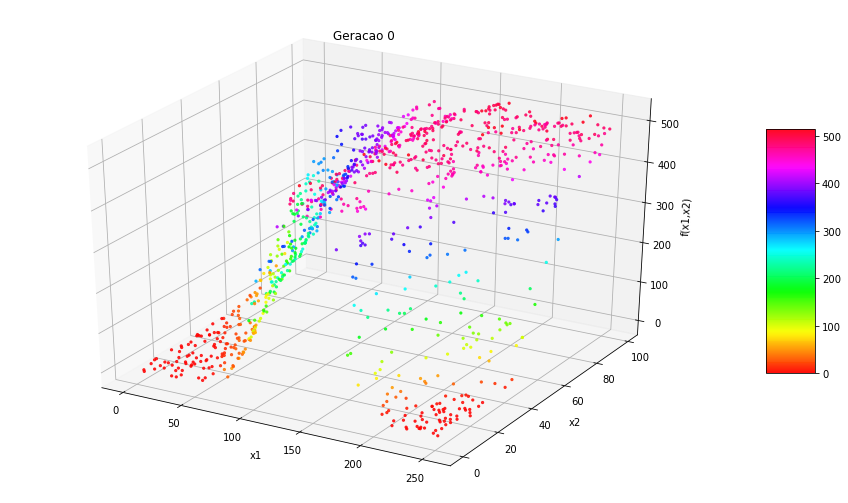

100%|██████████| 1000/1000 [06:41<00:00,  2.49it/s]


Geracao:  5


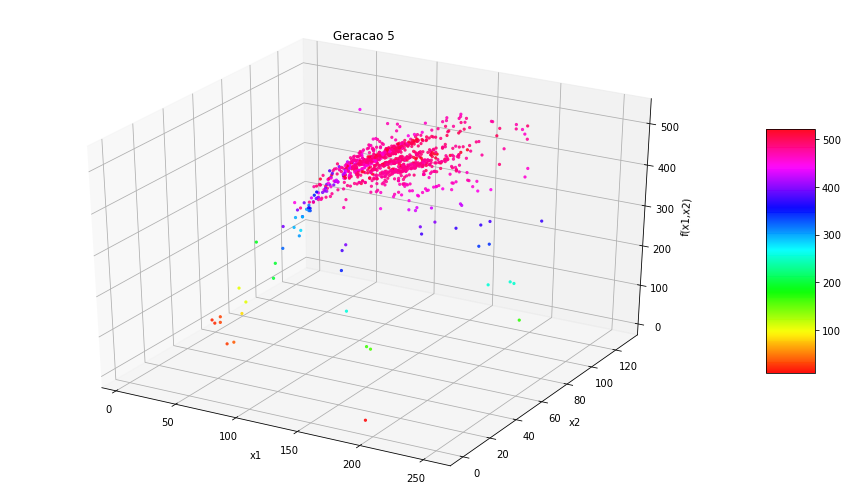

100%|██████████| 10/10 [47:02<00:00, 282.25s/it]


Melhor individuo individuo: 
Treshold: 158
Contrast:  30
Numero de neuronios:  520
Geracao:  9


,treshold,contrast
0,139,61
1,71,67
2,137,53
3,147,58
4,147,60
...,...,...
995,137,54
996,162,61
997,142,65
998,119,61


In [14]:
genetic_algorithm(tamanho_pop, tx_mutacao, tx_crossover, total_geracoes, image_path)
#[np.random.randint(0, 255, size=(tamanho_pop)), np.random.randint(0, 100, size=(tamanho_pop))]

## Análises

### Gráfico População por geração
Como podemos ver nos gráficos tridimensionais acima, nosso algorítmo apresentou uma rápida taxa de convergência, atingindo o máximo do espaço de buscas com poucas gerações. Isso aconteceu pois, os melhores indivíduos tem maior prioridades de seleção devido a função triangular aplicada para escolher um valor aleatório. Antes de utilizarmos este método, nosso algorítmo ficava convergino no máximo local em torno de 4.75 nas primeiras gerações. Após a aplicação conseguimos um máximo local proximo a 7.88 na maioria dos casos.

### Gráfico Evolução Temporal do algoritmo
O gráfico abaixo apresenta a evolução temporal do algorítmo genético que implementamos. Neste gráfico podemos notar que houve rápida convergência para o melhor resultado em poucas gerações. É possível ver também que os valores médios e máximos por geração são bem proximos, enquanto os piores estão bem abaixo.  

In [15]:
#plot_evolucao_temporal(melhor,media,pior)

### Gráfico evolução das variáveis por geração
O gráfico abaixo fizemos apenas para testar como as variáveis (x1 e x2) do pior e o melhor indivíduo e o valor médio da população de cada geração ficaram. Cada ponto representa uma geração diferente e os eixos são as variáveis. Algo interessante de notar é que os atributos dos melhores indivíduos apareceram bem próximos, enquanto o pior de cada geração apareceu bastante variado.

In [16]:
plot_variaveis_populacao(melhor,pior,media)

NameError: name 'melhor' is not defined

## Tabela Final
|       Genético       |                |
|:--------------------:|:--------------:|
| Tamanho da população |      1000      |
| Forma de seleção     |     Roleta     |
| Tipo de crossover    |   Aritmético   |
| Função objetivo      |     Alpine2    |
| Função de Fitness    | Ranking Linear |
| Número de Gerações   |       50       |
| Taxa de Crossover    |       0.8      |
| Taxa de Mutação      |      0.05      |